In [1]:
# Core imports
import numpy as np
from numpy import linalg as la 
import heyoka as hk
import pykep as pk
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint

# Sys imports
import time

# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Other imports
import dromo_const as const

%matplotlib notebook

In [2]:
GMe = const.GMe
Re = const.Re
J2 = const.J2

In [3]:
# Auxiliary function
def state2orb(r0, v0, Gparam, angle_unit):
    """
    Converts from state vector to orbital parameters
    units:
    r0 in km
    v0 in km/s
    Gparam in km^3/s^2
    a in km
    e is [-]
    angles in radiants (default) or degrees
    """
    h = np.cross(r0, v0)
    h_norm = np.linalg.norm(h)
    cos_inclination = h[2]/h_norm       # since h scalar product z = h_norm*1*cos(i) = h_3

    if np.linalg.norm(cos_inclination) >= 1:
        cos_inclination = np.sign(cos_inclination)
    inclination = math.acos(cos_inclination)
    inclination_d = math.degrees(inclination)

    if inclination == 0 or inclination == np.pi :
        node_line = [1, 0, 0] # None  # pick the x-axis as your line of Nodes, which is undefined as the orbital and equatorial plane coincide
        RAAN = 0  # None 
        RAAN_r = 0
    else :
        node_line = np.cross([0, 0, 1], h)/(np.linalg.norm(np.cross([0, 0, 1], h))) # cross vector is not commutative
        cos_RAAN = node_line[0]
        if np.linalg.norm(cos_RAAN) >= 1:
            cos_RAAN = np.sign(cos_RAAN)
        RAAN = math.acos(cos_RAAN)
        RAAN_d = math.degrees(RAAN)

    if node_line[1] < 0:
        RAAN = 2*np.pi - RAAN
        RAAN_d = math.degrees(RAAN)

    # From the Laplace vector equation 
    e = (np.cross(v0, h))/Gparam - r0/np.linalg.norm(r0)
    e_norm = np.linalg.norm(e)

    if e_norm < math.pow(10, -5):
        # for circular orbits choose r0 as the apse line to count the true anomaly and define the argument of perigee
        cos_arg_perigee = np.dot(r0, node_line)/np.linalg.norm(r0)
        if np.linalg.norm(cos_arg_perigee) >= 1:
            cos_arg_perigee = np.sign(cos_arg_perigee)
        arg_perigee = math.acos(cos_arg_perigee)
        arg_perigee_d = math.degrees(arg_perigee)
        if r0[2] < 0:
            arg_perigee = 2*np.pi - arg_perigee
            arg_perigee_d = math.degrees(arg_perigee)
        # arg_perigee =  # None 
    else :
        cos_arg_perigee = np.dot(e, node_line)/e_norm
        if np.linalg.norm(cos_arg_perigee) >= 1:
            cos_arg_perigee = np.sign(cos_arg_perigee)
        arg_perigee = math.acos(cos_arg_perigee)
        arg_perigee_d = math.degrees(arg_perigee)
        if e[2] < 0: # e1,e2,e3 dot 0,0,1
            arg_perigee = 2*np.pi - arg_perigee
            arg_perigee_d = math.degrees(arg_perigee)

    perigee = (np.linalg.norm(h)**2/Gparam) * (1/(1+e_norm))
    apogee  = (np.linalg.norm(h)**2/Gparam) * (1/(1-e_norm))

    if apogee < 0:
        # in the case of an hyperbolic orbit
        apogee = - apogee

    semi_major_axis = (perigee+apogee)/2
    T = (2*np.pi/math.sqrt(Gparam)) * math.pow(semi_major_axis, 3/2)  # orbital period (s)

    if e_norm < math.pow(10, -5):
        true_anomaly = 0
    else :
        cos_true_anomaly = np.dot(e, r0)/(e_norm*np.linalg.norm(r0))
        if np.linalg.norm(cos_true_anomaly) >= 1:
            cos_true_anomaly = np.sign(cos_true_anomaly)
        true_anomaly = math.acos(cos_true_anomaly)
        true_anomaly_d = math.degrees(true_anomaly)

    u_r  = r0/np.linalg.norm(r0)
    if np.dot(v0, u_r) < 0:
        # past apogee
        true_anomaly = 2*np.pi - true_anomaly   
        true_anomaly_d = math.degrees(true_anomaly)
        
    if angle_unit == "r":
        return semi_major_axis, e_norm, inclination, RAAN, arg_perigee, true_anomaly
    elif angle_unit == "d":
        return semi_major_axis, e_norm, inclination_d, RAAN_d, arg_perigee_d, true_anomaly_d
    else:
        raise("Insert a valid unit for the angle, r for radians, d for degree")

In [4]:
def orb2state(a, e_norm, i, RAAN, arg_perigee, true_anomaly):
    """
    This function takes as input the 6 orbital parameters and returns a state vector of the position and velocity
    a: semi-major axis (km)
    e_norm: the norm of the eccentricity vector
    i: inclination (rad)
    RAAN: right ascension of the ascending node (deg)
    arg_perigee: argument of perigee (deg)
    true_anomaly: theta (deg)
    """
    if e_norm < math.pow(10, -4):
        p = a
    elif e_norm > math.pow(10, -4) and e_norm < 1:
        b = a*math.sqrt(1 - e_norm**2)
        p = b**2/a
    elif e_norm == 1:
        p = 2*a
    elif e_norm > 1:
        b = a*math.sqrt(e_norm**2 - 1)
        p = b**2/a
    # p = h**2 / MU_earth
    h_norm = math.sqrt(p*GMe) 

    R3_Om = np.array( [[math.cos(RAAN), math.sin(RAAN), 0], [-math.sin(RAAN), math.cos(RAAN), 0], [0, 0, 1]] )
    R1_i  = np.array( [[1, 0, 0], [0, math.cos(i), math.sin(i)], [0, -math.sin(i), math.cos(i)]] )
    R3_om = np.array( [[math.cos(arg_perigee), math.sin(arg_perigee), 0], [-math.sin(arg_perigee), math.cos(arg_perigee), 0], [0, 0, 1]] )
    support_var = R3_om.dot(R1_i).dot(R3_Om)
    x = support_var[0, :]
    y = support_var[1, :]
    z = support_var[2, :]
    e_orb = e_norm * x
    h_orb = h_norm * z
    r_norm = (h_norm**2/GMe) * (1/(1+e_norm*math.cos(true_anomaly)))
    r_orb = r_norm*math.cos(true_anomaly)*x + r_norm*math.sin(true_anomaly)*y 
    u_radial = r_orb/r_norm
    u_normal = np.transpose( np.cross(z, u_radial)/np.linalg.norm(np.cross(z, u_radial)) )
    v_orb = (GMe/h_norm) * e_norm * math.sin(true_anomaly) * u_radial + (GMe/h_norm) * (1+e_norm*math.cos(true_anomaly)) * u_normal
    return r_orb, v_orb

In [67]:
def orb2state_parametric(a, e_norm, i, RAAN, arg_perigee, true_anomaly):
    """
    This function takes as input the 6 orbital parameters and returns a state vector of the position and velocity
    a: semi-major axis (km)
    e_norm: the norm of the eccentricity vector
    i: inclination (rad)
    RAAN: right ascension of the ascending node (deg)
    arg_perigee: argument of perigee (deg)
    true_anomaly: theta (deg)
    """
    # elliptic case only
    
    b = a* ( (1 - e_norm**2)**(1/2) )
    p = b**2/a
    
    h_norm = (p*GMe)**(1/2) 

    R3_Om = np.array( [[hk.cos(RAAN), hk.sin(RAAN), 0], [-hk.sin(RAAN), hk.cos(RAAN), 0], [0, 0, 1]] )
    R1_i  = np.array( [[1, 0, 0], [0, hk.cos(i), hk.sin(i)], [0, -hk.sin(i), hk.cos(i)]] )
    R3_om = np.array( [[hk.cos(arg_perigee), hk.sin(arg_perigee), 0], [-hk.sin(arg_perigee), hk.cos(arg_perigee), 0], [0, 0, 1]] )
    support_var = R3_om.dot(R1_i).dot(R3_Om)
    x = support_var[0, :]
    y = support_var[1, :]
    z = support_var[2, :]
    e_orb = e_norm * x
    h_orb = h_norm * z
    r_norm = (h_norm**2/GMe) * (1/(1+e_norm*hk.cos(true_anomaly)))
    r_orb = r_norm*hk.cos(true_anomaly)*x + r_norm*hk.sin(true_anomaly)*y 
    u_radial = r_orb/r_norm
    # Define the norm without the operation sqrt which is not supported by heyoka
    # substitude np.linalg.norm with the mathematical definition of norm:
    norm_hk = ((np.cross(z, u_radial)[0]**2 + np.cross(z, u_radial)[1]**2 + np.cross(z, u_radial)[2]**2)**(1/2)) 
    u_normal = np.transpose( np.cross(z, u_radial)/norm_hk )
    v_orb = (GMe/h_norm) * e_norm * hk.sin(true_anomaly) * u_radial + (GMe/h_norm) * (1+e_norm*hk.cos(true_anomaly)) * u_normal
    return r_orb, v_orb


In [65]:
# test hk norm
a = [3,4,5]
b = [1,2,3]

print(np.cross(a, b))
print( np.linalg.norm(np.cross(a, b)) )
print((np.cross(a, b)[0]**2 + np.cross(a, b)[1]**2 + np.cross(a, b)[2]**2)**(1/2))


[ 2 -4  2]
4.898979485566356
4.898979485566356


In [5]:
def plot2d_x_ys(x, ys, line_colors, h_label, v_label, line_styles, line_widths,\
                labels=None, style='seaborn-paper', markers=None):
    """
    Can plot on the same x axis more than one curve, to perform comparisons
    Inputs:
    x: on x axis
    ys: a list for the y axis
    style: 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 
    'fast', 'fivethirtyeight', 'ggplot', 'seaborn', 'seaborn-bright', 'seaborn-paper', 'seaborn-pastel', 
    'seaborn-colorblind','seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 
    'seaborn-poster','seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid'
    """
    plt.figure()
    plt.style.use(style)
    if markers == None:
        markers = ['']*len(ys)
    if labels == None:
        labels = ['']*len(ys)
    else:
        plt.legend()
    for idx in range(len(ys)):
        plt.plot(x, 
                ys[idx], 
                color = line_colors[idx],
                linestyle = line_styles[idx], 
                linewidth = line_widths[idx],
                marker = markers[idx],
                label = labels[idx]
                )
    plt.grid(True)
    plt.xlabel(h_label)
    plt.ylabel(v_label)
    plt.show()

In [43]:
def Dromo2orbel(sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    conversion from DROMO elements to classical orbital elements
    taken from page 15-16 of Urrutxua et al. paper 2015
    """
    a = - a0d / (zeta3**2 * (zeta1**2 + zeta2**2 -1))
    e_norm = (zeta1**2 + zeta2**2)**(1/2)
    beta = hk.atan(zeta2 / zeta1)  #np.arctan2(zeta2, zeta1)
    i = 2*hk.acos((eta3**2 + eta4**2)**(1/2))
    RAAN = - hk.atan(eta3 / eta4) + hk.atan(eta2 / eta1)
    omega_tilda = - hk.atan(eta3 / eta4) - hk.atan(eta2 / eta1)
    omega = omega_tilda + beta
    theta = sigma - beta
    return a, e_norm, i, RAAN, omega, theta

In [19]:
# create heyoka variables
tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4 = hk.make_vars( "tau",
                                                                        "zeta1",
                                                                        "zeta2",
                                                                        "zeta3",
                                                                        "eta1",
                                                                        "eta2",
                                                                        "eta3",
                                                                        "eta4")

# sigma is the independent variable (usually time), so I should not include it as hk variable? 
# (in both cases the error is the same )

In [20]:
# Initial Conditions (dimensional)
# @t=t0*, (x0*, v0*) and (a0*, e0*, i0*, RAAN0*, omega0*, theta0*)
r0d = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0d = np.array([10.691338, 0.0, 0.0])      #km/s
# perigee height should be 6800 km (correct!, as the minimum altitude comes out to be 428 km)
[a0d, e0d, i0d, RAAN0d, omega0d, theta0d] = state2orb(r0d, v0d, GMe, "r")

# from the conversion comes out that a0* = 136,000 km
# and that the orbital and equatorial plane coincide, as i~=0 and RAAN is not defined

# Non-dimensionalise the ICs
r0 = r0d / a0d #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0 = r0d/la.norm(r0d)
v0 = v0d * math.sqrt(a0d/GMe)       #[-]
t0d = 0                                   #s
t0  = t0d / math.sqrt((a0d**3)/GMe) #[-]

# Tranform the non-dimensional ICs (r0, v0) in DROMO elements: (sigma; tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
h0 = np.cross(r0, v0)                    # 3-components vector
e0 = - r0/la.norm(r0) - np.cross(h0, v0) # 3-components vector
sigma_0 = 0
tau_0   = t0
zeta1_0 = la.norm(e0)
zeta2_0 = 0
zeta3_0 = 1/la.norm(h0)
eta1_0  = math.sin(i0d/2)*math.cos((RAAN0d-omega0d)/2)
eta2_0  = math.sin(i0d/2)*math.sin((RAAN0d-omega0d)/2)
eta3_0  = math.cos(i0d/2)*math.sin((RAAN0d-omega0d)/2)
eta4_0  = math.cos(i0d/2)*math.cos((RAAN0d-omega0d)/2)

S0 = [tau_0, zeta1_0, zeta2_0, zeta3_0, eta1_0, eta2_0, eta3_0, eta4_0]

In [47]:
print( Dromo2orbel(sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)) 

((-136000.41845656614 / (square(zeta3) * ((square(zeta1) + square(zeta2)) - 1.0000000000000000))), sqrt((square(zeta1) + square(zeta2))), (2.0000000000000000 * acos(sqrt((square(eta3) + square(eta4))))), (-atan((eta3 / eta4)) + atan((eta2 / eta1))), ((-atan((eta3 / eta4)) - atan((eta2 / eta1))) + atan((zeta2 / zeta1))), (t - atan((zeta2 / zeta1))))


In [68]:
print( orb2state_parametric( *Dromo2orbel(sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)) )

(array([(((((square(sqrt(((square(((-136000.41845656614 / (square(zeta3) * ((square(zeta1) + square(zeta2)) - 1.0000000000000000))) * sqrt((1.0000000000000000 - square(sqrt((square(zeta1) + square(zeta2)))))))) / (-136000.41845656614 / (square(zeta3) * ((square(zeta1) + square(zeta2)) - 1.0000000000000000)))) * 398601.00000000000))) / 398601.00000000000) * (1.0000000000000000 / (1.0000000000000000 + (sqrt((square(zeta1) + square(zeta2))) * cos((t - atan((zeta2 / zeta1)))))))) * cos((t - atan((zeta2 / zeta1))))) * ((cos(((-atan((eta3 / eta4)) - atan((eta2 / eta1))) + atan((zeta2 / zeta1)))) * cos((-atan((eta3 / eta4)) + atan((eta2 / eta1))))) + ((sin(((-atan((eta3 / eta4)) - atan((eta2 / eta1))) + atan((zeta2 / zeta1)))) * cos((2.0000000000000000 * acos(sqrt((square(eta3) + square(eta4))))))) * -sin((-atan((eta3 / eta4)) + atan((eta2 / eta1))))))) + ((((square(sqrt(((square(((-136000.41845656614 / (square(zeta3) * ((square(zeta1) + square(zeta2)) - 1.0000000000000000))) * sqrt((1.000000

In [21]:
sigma = hk.time

In [22]:
# Auxiliary relationships
s = 1 + zeta1 * hk.cos(sigma) + zeta2 * hk.sin(sigma)

In [80]:
model = "keplerian"

if model == "keplerian":
    
    # Keplerian motion
    apx = 0
    apy = 0
    apz = 0
    
elif model == "J2":
    
    pos, vel = orb2state_parametric(*Dromo2orbel(sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4))
    # print(pos)
    x, y, z = pos[0], pos[1], pos[2]
    # xv, yv, zv = vel[0], vel[1], vel[2]
    r_norm = (x**2 + y**2 + z**2)**(1/2)
    apxd = ( (3/2)*J2*GMe*Re**2/r_norm**4 ) * (x/r_norm)*(5*(z**2/r_norm**2) -1) # x-component of dimensional perturbing acceleration
    apyd = ( (3/2)*J2*GMe*Re**2/r_norm**4 ) * (y/r_norm)*(5*(z**2/r_norm**2) -1) # y-component of dimensional perturbing acceleration
    apzd = ( (3/2)*J2*GMe*Re**2/r_norm**4 ) * (z/r_norm)*(5*(z**2/r_norm**2) -3) # z-component of dimensional perturbing acceleration
    apx = apxd * (a0d**2/GMe)
    apy = apyd * (a0d**2/GMe)
    apz = apzd * (a0d**2/GMe)


In [81]:
# Perturbing accelerations
a_px = apx/(zeta3**4 * s**3)
a_py = apy/(zeta3**4 * s**3)
a_pz = apz/(zeta3**4 * s**3)

In [82]:
# EOMs

dtaudsigma    = 1/(zeta3**3 * s**2)
dzeta1dsigma  = s * hk.sin(sigma) * a_px   + (zeta1 + (1+s)*hk.cos(sigma)) * a_py
dzeta2dsigma  = - s * hk.cos(sigma) * a_px + (zeta2 + (1+s)*hk.sin(sigma)) * a_py
dzeta3dsigma  = zeta3 * a_pz
deta1dsigma   = 1/2 * a_pz * (eta4 * hk.cos(sigma) - eta3 * hk.sin(sigma))
deta2dsigma   = 1/2 * a_pz * (eta3 * hk.cos(sigma) + eta4 * hk.sin(sigma))
deta3dsigma   = 1/2 * a_pz * (-eta2* hk.cos(sigma) + eta1 * hk.sin(sigma))
deta4dsigma   = 1/2 * a_pz * (-eta1* hk.cos(sigma) - eta2 * hk.sin(sigma))

In [83]:
# Define time

# tf = 288.12768941*24*3600            # s
tf = 2*np.pi * 50                      # roughly 50 orbits
delta_t = 1
n_steps = math.floor((tf-t0)/delta_t - 1)
# duration of integration in seconds
tspan = np.linspace(0, tf, n_steps)

In [84]:
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(tau,dtaudsigma),(zeta1,dzeta1dsigma),
                               (zeta2,dzeta2dsigma),(zeta3,dzeta3dsigma),
                               (eta1,deta1dsigma),(eta2,deta2dsigma),
                               (eta3,deta3dsigma),(eta4,deta4dsigma)],
                        
                                state = S0,
                                time = sigma_0,
                                tol = 1e-16,
                                compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 0.22720909118652344 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 8
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, 0.95000015413507921, 0.0000000000000000, 3.2025678858149962, -0.18301270304063941, -0.18301270304063944, -0.68301270158450111, -0.68301270158450100]



In [85]:
tmax = 288.12768941*24*60*60 #[sec]

# How often to log the state
dt = 3600 #[sec]

# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  [*S0]

In [86]:
print('Numerically propagating the orbit for {} days'.format(tmax/(24*3600)))

tgrid = np.linspace(t0, tmax, int(1 + tmax/dt), endpoint = True)

start_time = time.time()
out = ta.propagate_grid(tgrid)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
sol = out[4] 
print(sol)
size = np.shape(sol)
print(f'the shape of the solution (dromo formulation) is {size}')
#np.savetxt('sim_hK_dromo_001.txt', sol)



Numerically propagating the orbit for 288.1276894100001 days
Done, in
--- 149.2746081352234 seconds ---
[[ 0.00000000e+00  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]
 [ 3.60026331e+03  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]
 [ 7.20052652e+03  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]
 ...
 [ 2.48870310e+07  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]
 [ 2.48906313e+07  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]
 [ 2.48942315e+07  9.50000154e-01  0.00000000e+00 ... -1.83012703e-01
  -6.83012702e-01 -6.83012702e-01]]
the shape of the solution (dromo formulation) is (6916, 8)


<IPython.core.display.Javascript object>


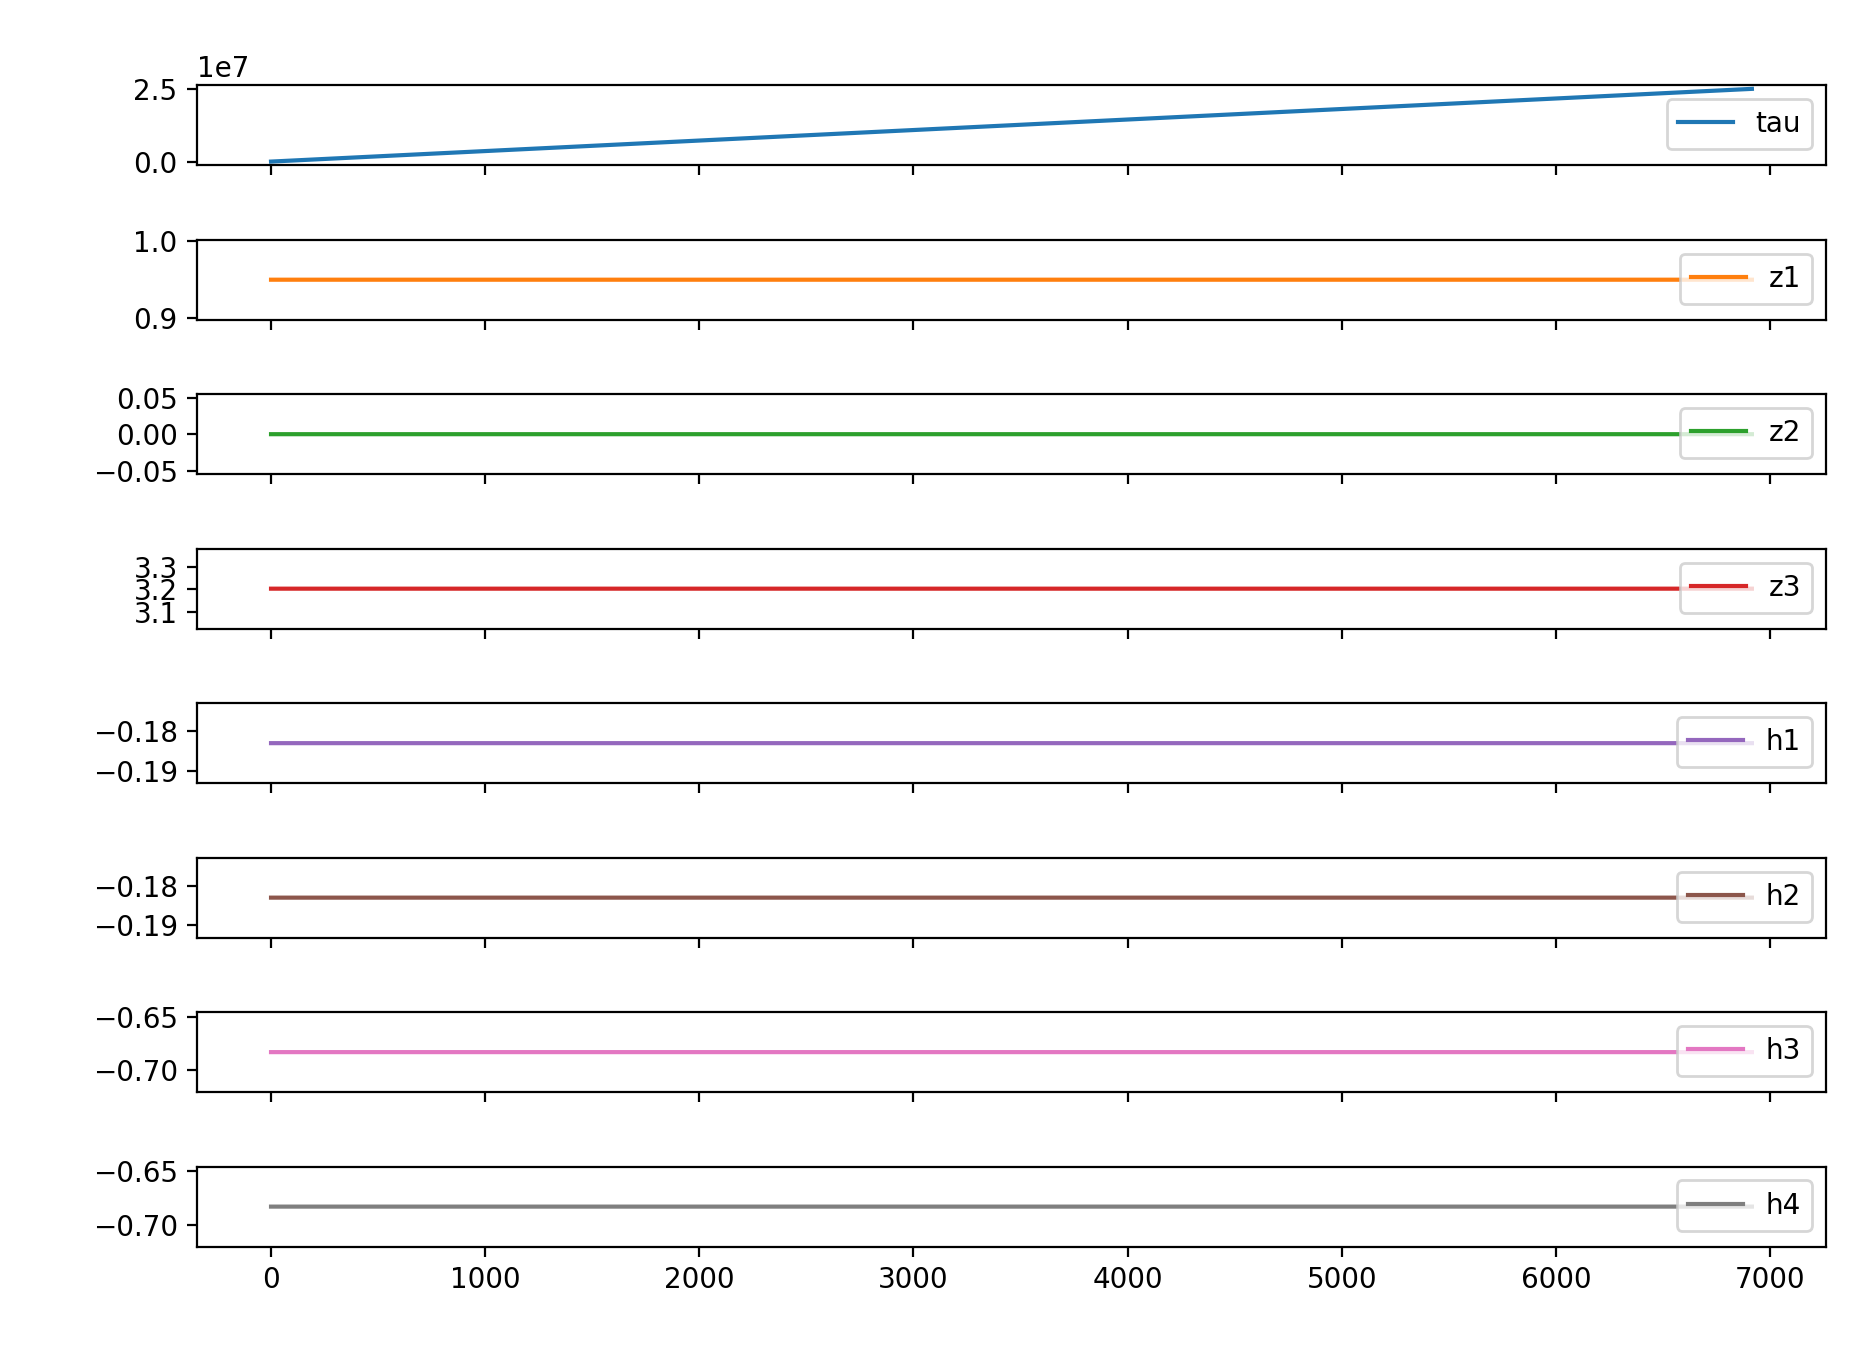

In [87]:
df = pd.DataFrame(sol, columns=["tau", "z1", "z2", "z3", "h1", "h2", "h3", "h4"])
    
df.plot(subplots=True)
plt.tight_layout()
plt.show()


In [79]:
dromo2orb_res = []
dromo2orb_res.append(Dromo2orbel(sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4))

df = pd.DataFrame(dromo2orb_res, columns=["a", "e", "i", "RAAN", "omega", "theta"])
# print(df)
df.plot(subplots=True)
plt.tight_layout()
plt.show() 

TypeError: no numeric data to plot